### Cell 0 – Repository Setup (Colab Only)

**Purpose**: This cell exists only for Google Colab execution. It ensures the correct repository and branch are downloaded before running the experiment.

**What Happens**:
- Clones the GitHub repository
- Selects the trajectory_tracking_policy branch
- Sets the project root so Python can resolve imports correctly

In [ ]:
import sys
import os

# 1. Clone the repository
!git clone -b trajectory_tracking_policy https://github.com/orc-podavini-grisenti/final_assignment

# 2. Point the project_root specifically to the cloned folder
# In Colab, the folder structure will be /content/final_assignment/
project_root = os.path.abspath('/content/final_assignment')

# 3. Add that specific folder to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


# 4. Link the Drive to the colab in order to store the results
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/final_assignment/outputs/models_saved"

# Crea la cartella se non esiste
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

fatal: destination path 'final_assignment' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cell 1: Imports & Global Setup

**Purpose**: This cell initializes all core dependencies and defines shared configuration variables.

In [40]:
import sys
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from planner.dubins_planner import DubinsPlanner
from models.trajectory_tracking_network import TTNetwork
from models.value_network import ValueNetwork
from utils.normalization import ObservationNormalizer
from utils.reward import TrajectoryTrackingReward

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### Cell 2: Experiment Configuration 

**Purpose**: Defines hyperparameters and experiment-level settings.

In [41]:
# Hyperparameters
MAX_EPISODES = 4000
MAX_STEPS    = 200
POLICY_LR    = 1e-3
VALUE_LR     = 1e-3
BATCH_SIZE   = 32
GAMMA        = 0.99

SEED         = 0        # Seed for reproducibility
PATIENCE     = 10       # Stop after 10 updates (200 episodes) without improvement

EXPERIMENTS_PATH = drive_path if 'drive_path' in locals() else "experiments/"

# Global Output Directory
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"run_{current_time}"

output_dir = os.path.join(EXPERIMENTS_PATH, run_id)
os.makedirs(output_dir, exist_ok=True)

print(f"Results will be saved to: {output_dir}")

Results will be saved to: experiments/run_20260108_112649


### Cell 3 – Environment Initialization

**Purpose** = Creates the reinforcement learning environment.

In [ ]:
# --- MENAGE THE SEED for REPRODUCIBILITY --- 
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to: {seed}")

set_seed(SEED)


# --- 3. INIT THE ENVIROMENT ---
env = UnicycleEnv()




# --- 6. INIT THE REWARD CALCULATOR --- 
reward_calculator = TrajectoryTrackingReward()


# --- 7. OTHER VARIABLE INIT ---
gamma = GAMMA

# Memory buffer for the current episode
log_probs = []
rewards = []

# Memory buffer for the batch
value_loss_history = [] # Store the MSE loss of the value network
loss_history = [] # Store all the batch losses

batch_log_probs = []        # store the actions log probabilities of an entire batch [ used during the update ]
batch_returns = []          # store the Retunr To Go of an entire batch [ used during the update ]
batch_obs = []              # store states for fitting the baseline


Seed set to: 0


### Cell 4: Networks Initialization
We use two network:

    1. TTNetwork: Trajectory Tracking Network, out policy that should learn which action take
    2. ValueNetwork: Learn to estimate the value function, used as baseline 

In [ ]:
# 1. POLICY NETWORK
obs_dim = 3     # Obs dim is 3 (rho, alpha, d_theta)
action_dim = 2  # v, omega

policy = TTNetwork(obs_dim, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=POLICY_LR)
# This helps the network "settle" into the precise solution
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5) # Reduces LR by factor of 0.5 every 200 episodes

# Normalizer for the Policy Input
obs_normalizer = ObservationNormalizer(max_dist=3.0)


# 2. VALUE FUNCTION NETWORK
value_net = ValueNetwork(obs_dim).to(device)
value_optimizer = optim.Adam(value_net.parameters(), lr=VALUE_LR)
value_criterion = nn.MSELoss()


### Cell 5: Helpers

In [43]:
def get_tracking_obs(target_waypoint, robot_state):
    # 1. Compute errors relative to this specific waypoint   
    dx = target_waypoint[0] - robot_state[0]
    dy = target_waypoint[1] - robot_state[1]
    
    # Rho: Distance to the target waypoint
    rho = np.sqrt(dx**2 + dy**2)
    
    # Alpha: Angle to the target waypoint (relative to robot heading)
    theta = env.state[2]
    alpha = np.arctan2(dy, dx) - theta
    # Normalize alpha to [-pi, pi]
    alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
    
    # D_theta: Orientation error (target heading - robot heading)
    target_heading = target_waypoint[2]
    d_theta = target_heading - theta
    # Normalize d_theta to [-pi, pi]
    d_theta = (d_theta + np.pi) % (2 * np.pi) - np.pi

    # 3. Create the new tracking observation
    # This replaces: tracking_obs = obs[:3]
    tracking_obs = np.array([rho, alpha, d_theta], dtype=np.float32)
    return tracking_obs


def get_action(obs):
    """Samples an action and stores its log_probability."""
    # Use the imported normalizer to normaliza the inputs features to give the same relevance
    norm_obs = obs_normalizer.normalize_tt(obs)

    obs_t = torch.FloatTensor(norm_obs).unsqueeze(0).to(device)

    # Policy Forward 
    mean, std = policy(obs_t)
    dist = Normal(mean, std)
    # Sample a randome action from this distribution
    action = dist.sample()      # NB: randomcicity ensure exploration

    # Store for update
    log_prob = dist.log_prob(action).sum(dim=1)
    log_probs.append(log_prob)
    # Store the normalized observation for the baseline update
    batch_obs.append(obs_t)

    # Return numpy action for the environment
    # Clip to ensure physical validity [-1, 1]
    return np.clip(action.cpu().detach().numpy()[0], -1.0, 1.0)


def store_reward(reward):
    rewards.append(reward)

def store_batch_loss(loss):
    loss_history.append(loss)


def sample_radius(mean=1.65, std=0.3, min_r=1, max_r=2.5, size=1):
    """
    Samples a radius using a Gaussian distribution, strictly constrained.
    """
    # 1. Sample from the normal distribution
    samples = np.random.normal(loc=mean, scale=std, size=size)

    # 2. Hard constrain using clipping
    constrained_samples = np.clip(samples, min_r, max_r)

    return constrained_samples[0] if size == 1 else constrained_samples


def sample_seed(min_seed=100):
    """ 
    Samples a random seed (min 100 - the first hundred are reserved for evaluation)
    """
    return random.randint(min_seed, 100000)

### Cell 6: Exploit Casuality 
*from cost to go to return to go*

In [44]:
def calculate_discounted_returns():
    """
    Calculates the 'Return-to-Go' (G_t) for the current episode using causality.

    Mathematical Concept:
    Instead of using the total reward C(tau) for every step, we use G_t:
    G_t = sum_{k=t}^H gamma^(k-t) * r_k

    This reduces variance because actions at time 't' are only reinforced
    based on rewards that happen *after* time 't' (Causality).
    """
    global log_probs, rewards, batch_log_probs, batch_returns

    G_t = 0
    returns = []

    # 1. Calculate Discounted Returns (Backwards)
    # We iterate backwards to easily compute G_t = r_t + gamma * G_{t+1}
    for r in reversed(rewards):
        G_t = r + gamma * G_t
        returns.insert(0, G_t)

    # 2. Store for the Batch Update
    # We do NOT normalize here. We wait to collect all episodes in the batch
    # so we can normalize across the entire dataset (Batch-wise normalization).
    batch_log_probs.extend(log_probs)
    batch_returns.extend(returns)

    # Clear episode memory
    log_probs = []
    rewards = []


### Cell 7: Reinforce Update - With State-Value Baseline

1. PREPARE BATCH DATA:
   - Convert the list of cumulative returns (G_t) into a tensor.
   - Reshape returns to (N, 1) to ensure compatibility with network output.
   - Concatenate all observations from the batch into a single tensor.

2. UPDATE VALUE NETWORK (THE CRITIC/BASELINE):
   - Perform a forward pass to predict state values V(x_t).
   - Calculate the Mean Squared Error (MSE) loss: ||V(x_t) - G_t||^2.
   - Backpropagate the error and update Value Network weights to minimize prediction error.

3. CALCULATE AND NORMALIZE ADVANTAGE (A_t):
   - Compute the Advantage: A_t = G_t - V(x_t).
   - Detach predicted values to prevent policy gradients from affecting the Baseline.
   - Apply Batch-Wise Normalization to A_t to stabilize the scale of policy updates.

4. CALCULATE POLICY LOSS:
   - Iterate through sampled actions to calculate: Policy Loss = -log(π(u_t | x_t)) * A_t.
   - The Advantage (A_t) determines the direction and magnitude of the reinforcement.

5. UPDATE POLICY NETWORK:
   - Sum individual losses and average them by the Batch Size.
   - Perform backpropagation to calculate policy gradients.
   - Apply gradient clipping and update policy parameters (theta).

6. CLEANUP & MEMORY MANAGEMENT:
   - Clear all batch-level buffers (log_probs, returns, observations).
   - This is critical to prevent memory leaks and redundant data accumulation.

In [45]:
def update():
    global batch_log_probs, batch_returns, batch_obs, value_loss_history, optimizer, value_optimizer

    if len(batch_returns) == 0:
        return

    # 1. PREPARE BATCH DATA:
    # Convert the list of cumulative returns (G_t) into a tensor.
    # Reshape returns to (N, 1) to ensure compatibility with network output.
    returns_t = torch.tensor(batch_returns).float().to(device).view(-1, 1)
    # Concatenate all observations from the batch into a single tensor.
    obs_t = torch.cat(batch_obs, dim=0) 


    # 2. UPDATE VALUE NETWORK (THE CRITIC/BASELINE):
    # Perform a forward pass to predict state values V(x_t).
    value_optimizer.zero_grad()
    values = value_net(obs_t)
    # Calculate the Mean Squared Error (MSE) loss: ||V(x_t) - G_t||^2.
    value_loss = value_criterion(values, returns_t)
    # Backpropagate the error and update Value Network weights to minimize prediction error.
    value_loss.backward()
    value_optimizer.step()
    
    # Store value loss for the new plot
    value_loss_history.append(value_loss.item())


    # 3. CALCULATE AND NORMALIZE ADVANTAGE (A_t):
    # Compute the Advantage: A_t = G_t - V(x_t).
    with torch.no_grad():
        advantages = (returns_t - values.detach())
    
    # Apply Batch-Wise Normalization to A_t to stabilize the scale of policy updates.
    if len(advantages) > 1:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


    # 4. CALCULATE POLICY LOSS:
    # Iterate through sampled actions to calculate: Policy Loss = -log(π(u_t | x_t)) * A_t.
    policy_loss = []    # buffer to store the loss of each action in the batch
    for log_prob, adv in zip(batch_log_probs, advantages):
        policy_loss.append(-log_prob * adv)


    # 5. UPDATE POLICY NETWORK
    # Sum individual losses and average them by the Batch Size.
    loss = torch.stack(policy_loss).sum() / BATCH_SIZE
    # Perform backpropagation to calculate policy gradients.
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping and update policy parameters.
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()


    # 6. CLEANUP & MEMORY MANAGEMENT:
    # This is critical to prevent memory leaks and redundant data accumulation.
    store_batch_loss(loss.item())
    # Clear all batch-level buffers (log_probs, returns, observations).
    batch_log_probs.clear()
    batch_returns.clear()
    batch_obs.clear()

### Cell 8: Training

In [46]:
episode_reward_history = []                 # Store the reward for each episode ( used for final plotting )
batch_reward_history = []

best_avg_reward = -float('inf')
no_improvement_count = 0
output_model_path = output_dir + '/policy_model.ph'

print("Starting Training...")

# Run all the episodes
for episode in range(MAX_EPISODES):
    # Each episode is a different enviroment configuration
    seed = sample_seed()
    obs, info = env.reset(seed)

    start_pose = env.state
    goal_pose = env.goal

    # We change also the minimum radius of the dubins curve
    random_radius = sample_radius()
    planner = DubinsPlanner(curvature=random_radius, step_size=0.2)
    path = planner.get_path(start_pose, goal_pose)
    if path is None: continue

    path_idx = 0
    ep_reward = 0
    episode_errors = []
    breack_reason = "Max step reached"

    for t in range(MAX_STEPS):
        old_idx = path_idx

        # --- 1. Forward: The network choose the action ---
        target_waypoint = path[path_idx]        # The goal is to reach the next waypoint of the path
        # Input of the network is the Ego-Centric Observation Vector: 
        #   1. rho (ρ): [0, inf]        Euclidean distance to the goal.        
        #   2. alpha (α): [-pi, pi]     The angle of the goal *relative* to the robot's current heading.
        #   3. d_theta (δθ): [-pi, pi]  The difference between the desired goal orientation and current heading.
        tracking_obs = get_tracking_obs(target_waypoint, env.state[:2])       
        action = get_action(tracking_obs)

        # --- 2. Environment Step ---
        obs, terminated, truncated, info = env.step(action)


        # --- 3. Update Path Tracking Logic ---
        # ( understand which waypoint of the track the robot is near)
        # 1) extract all the path waypoints (x,y) coordinates
        path_xy = path[:, :2]           
        # 2) compute the distance between the current robot position and all the waypoints                            
        dists = np.linalg.norm(path_xy - env.state[:2], axis=1)     
        # 3) take the minimum distance, this is consider as the 'tracking error'
        current_tracking_error = np.min(dists)             # current_tracking_error = 'distance to the closest waypoint'    
        episode_errors.append(current_tracking_error)

        # 4) Derive the waypoint id closest to the robot, it tell us the robot position respect to the path
        closest_idx = np.argmin(dists)
        # 5) Now the goal of the robot is to reach the next waypoint 
        lookahead_idx = closest_idx + 1
        # This check is used to menage strang behavior as the robot by moving randomly go revers to the path
        if lookahead_idx > path_idx and lookahead_idx < len(path):
            path_idx = lookahead_idx


        # 3. --- Calculate Step Reward ---
        # Calculate checkpoints cleared
        checkpoints_cleared = max(0, path_idx - old_idx)
        terminal_reason = None 
        if info['is_success']:
            terminated = True
            terminal_reason = "goal"
            breack_reason = "Goal Reached"
        elif info['collision']:
            terminated = True
            terminal_reason = "collision"
            breack_reason = "Collision"
        elif current_tracking_error > 2.0:
            terminated = True
            terminal_reason = "off_path"
            breack_reason = "Off the Path"
        elif t >= MAX_STEPS - 1:
            truncated = True
            terminal_reason = "timeout"
        
        # 4. Compute the Reward
        # Pass the tracking observation (rho, alpha, d_theta), action, and status
        step_reward = reward_calculator.compute_reward(
            tracking_obs=tracking_obs,
            action=action,
            checkpoints_cleared=checkpoints_cleared,
            terminal_reason=terminal_reason
        )

        # 5. Store and Accumulate
        store_reward(step_reward)
        ep_reward += step_reward

        # 6. Brake the episod if it is terminated or truncated
        if terminated or truncated:
            break

    # Update logic (discounting, logging, etc.)
    calculate_discounted_returns()
    avg_error = np.mean(episode_errors)
    episode_reward_history.append(ep_reward)

    # 4. If we have collected 'm' trajectories, perform the update
    if (episode + 1) % BATCH_SIZE == 0:
        update() 
        print(f"Update performed at episode {episode}")

        avg_r = np.mean(episode_reward_history[-BATCH_SIZE:]) # Average reward of the last batch
        batch_reward_history.append(avg_r)
        
        # --- EARLY STOPPING LOGIC ---
        if avg_r > best_avg_reward:
            best_avg_reward = avg_r
            no_improvement_count = 0
            
            # STORE THE BEST VERSION OF THE WEIGHTS
            torch.save(policy.state_dict(), output_model_path)
            print(f"Update {episode//BATCH_SIZE} | New Best: {best_avg_reward:.2f} | Model Saved.")
        else:
            no_improvement_count += 1
            print(f"Update {episode//BATCH_SIZE} | Avg Reward: {avg_r:.2f} | Patience: {no_improvement_count}/{PATIENCE}")

        if no_improvement_count >= PATIENCE:
            print(f"Early stopping triggered: No improvement for {PATIENCE} updates.")
            break

print(f"Training Complete. Best average reward: {best_avg_reward:.2f}")

Starting Training...
Update performed at episode 31
Update 0 | New Best: 32.07 | Model Saved.
Update performed at episode 63
Update 1 | New Best: 53.75 | Model Saved.
Update performed at episode 95
Update 2 | New Best: 112.60 | Model Saved.
Update performed at episode 127
Update 3 | New Best: 133.33 | Model Saved.
Update performed at episode 159
Update 4 | Avg Reward: 110.68 | Patience: 1/10
Update performed at episode 191
Update 5 | New Best: 142.51 | Model Saved.
Update performed at episode 223
Update 6 | New Best: 156.39 | Model Saved.
Update performed at episode 255
Update 7 | New Best: 181.38 | Model Saved.
Update performed at episode 287
Update 8 | New Best: 216.58 | Model Saved.
Update performed at episode 319
Update 9 | Avg Reward: 205.18 | Patience: 1/10
Update performed at episode 351
Update 10 | New Best: 281.61 | Model Saved.
Update performed at episode 383
Update 11 | New Best: 295.81 | Model Saved.
Update performed at episode 415
Update 12 | Avg Reward: 229.63 | Patience:

### Cell 9: Visualization & Save
Plot the learning curve to verify convergence.

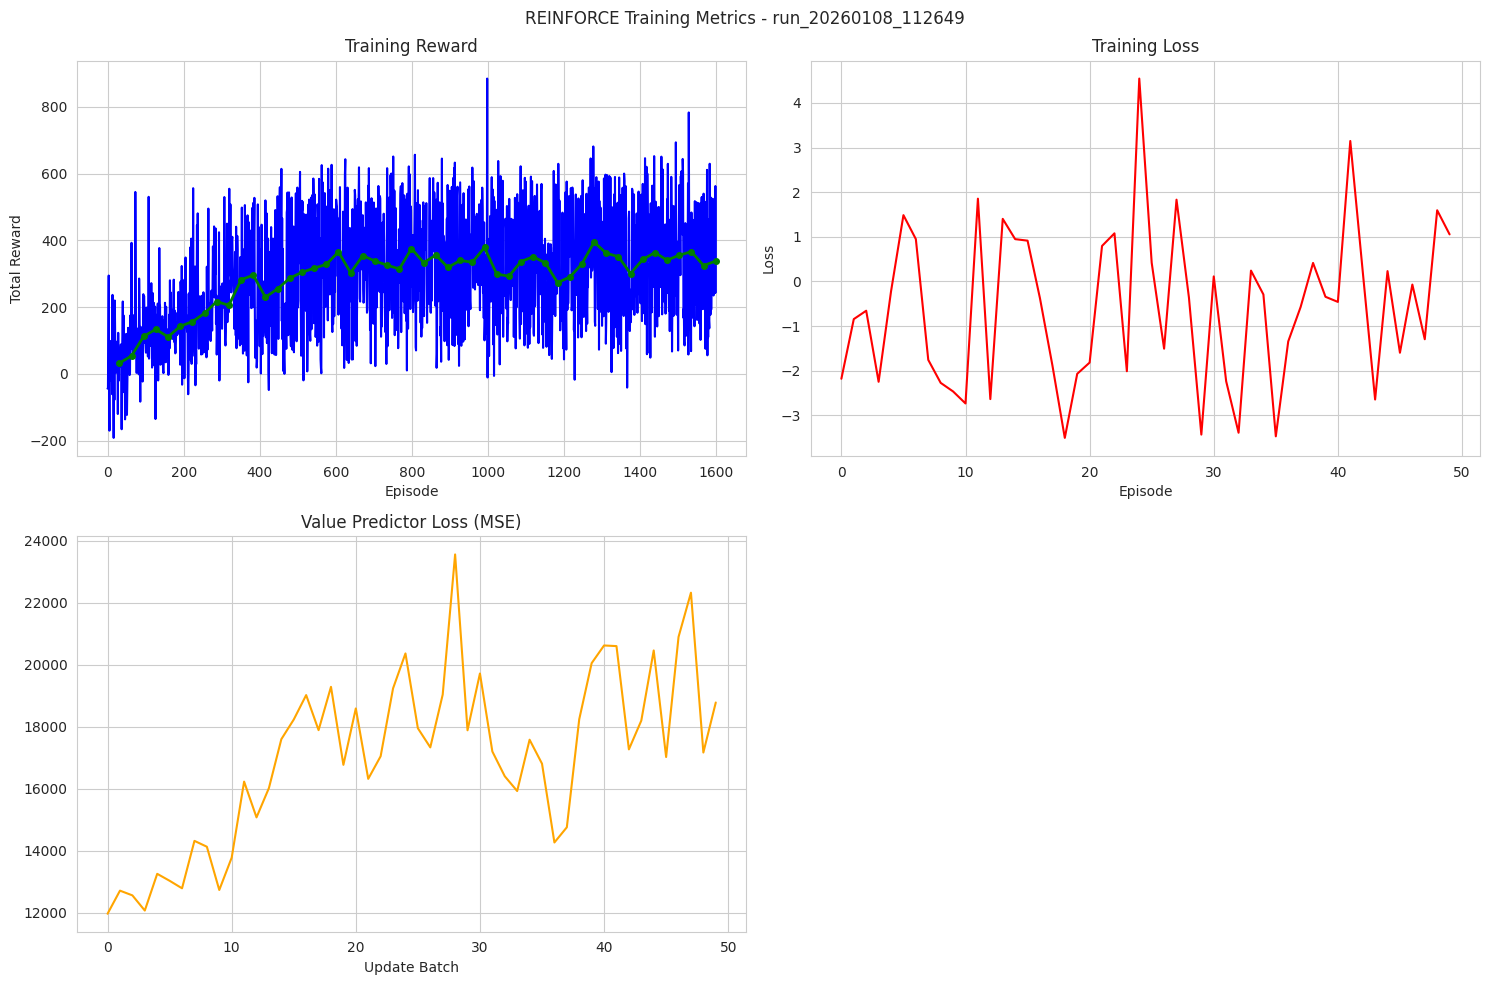

------------------------------
Execution complete.
Directory: experiments/run_20260108_112649
Saved: experiments/run_20260108_112649/policy_model.ph, training_metrics_plot.png, histories (.npy)
------------------------------


In [47]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. PLOTTING AND SAVING FIGURES ---
# We create a figure with 3 subplots (1 row, 3 columns)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Process histories to ensure they are plottable (handle tensors)
clean_episodes_rewards = [r.detach().cpu().item() if torch.is_tensor(r) else r for r in episode_reward_history]
clean_batch_rewards =  [r.detach().cpu().item() if torch.is_tensor(r) else r for r in batch_reward_history]
clean_losses = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in loss_history]
clean_val_losses = [v for v in value_loss_history]

# Plot 1: Total Reward
ax1.plot(clean_episodes_rewards, color='blue')
batch_x_axis = (np.arange(len(clean_batch_rewards)) + 1) * BATCH_SIZE - 1
ax1.plot(batch_x_axis, clean_batch_rewards, color='green', marker='o', markersize=4, 
         linewidth=2, label='Batch Avg Reward')
ax1.set_title("Training Reward")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.grid(True)

# Plot 2: Training Loss
# Note: Ensure you are appending your loss values to a list named 'loss_history' during training
ax2.plot(clean_losses, color='red')
ax2.set_title("Training Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Loss")
ax2.grid(True)

# Plot 3: Value Predictor Loss (MSE)
ax3.plot(value_loss_history, color='orange')
ax3.set_title("Value Predictor Loss (MSE)")
ax3.set_xlabel("Update Batch")
ax3.grid(True)

# Plot 4: Empty or Placeholder
ax4.axis('off')

# Save the combined plot
plt.suptitle(f"REINFORCE Training Metrics - {run_id}")
plt.tight_layout() # Adjust spacing so titles don't overlap
plot_filename = "training_metrics_plot.png"
plt.savefig(os.path.join(output_dir, plot_filename))
plt.show()

# --- 3. SAVING DATA ---
# Save both histories for future analysis
np.save(os.path.join(output_dir, "episode_reward_history.npy"), np.array(clean_episodes_rewards))
np.save(os.path.join(output_dir, "batch_reward_history.npy"), np.array(clean_batch_rewards))
np.save(os.path.join(output_dir, "loss_history.npy"), np.array(clean_losses))

print("-" * 30)
print(f"Execution complete.")
print(f"Directory: {output_dir}")
print(f"Saved: {output_model_path}, {plot_filename}, histories (.npy)")
print("-" * 30)

### Cell 10: Evaluation

In [48]:
from evaluation.controllers_evaluation import evaluate_single_model

report_path = output_dir + '/evaluation_report.txt'
evaluate_single_model(output_model_path, "last_run", 50, 0, 
                      verbose=True, save_csv=False, txt_file_path=report_path)

--> Loading Model: experiments/run_20260108_112649/policy_model.ph
RL Controller loaded successfully on cuda
Starting 50 episodes...
Progress: 50/50
Evaluation Complete.

 EVALUATION REPORT: last_run
╒══════════════╤══════════════╤═══════════════╤═══════════════════╤══════════════╤═════════════════╕
│ Metric       │ Value        │ Metric        │ Value             │ Metric       │ Value           │
╞══════════════╪══════════════╪═══════════════╪═══════════════════╪══════════════╪═════════════════╡
│ Status       │ ✅ EXCELLENT │ Mean CTE      │ 0.0090 ± 0.0046 m │ Avg Velocity │ 0.83 ± 0.02 m/s │
├──────────────┼──────────────┼───────────────┼───────────────────┼──────────────┼─────────────────┤
│ Success Rate │ 100.0 %      │ Max CTE (Avg) │ 0.0222 m          │ Smoothness   │ 0.0603 ± 0.0558 │
├──────────────┼──────────────┼───────────────┼───────────────────┼──────────────┼─────────────────┤
│ Steps (Avg)  │ 240.1 ± 80.8 │ Tortuosity    │ 0.995 ± 0.013     │ Avg Energy   │ 9.93 ± 2.95

### Cell 11: ⚠ Delete the train directory ( only for bed results )

In [ ]:
import shutil

# --- DELETE CURRENT EXPERIMENT DIRECTORY ---
# Ask for confirmation to prevent accidental deletion
confirm = input(f"Do you want to delete the directory '{run_id}'? (y/n): ")

if confirm.lower() == 'y':
    try:
        # shutil.rmtree deletes a directory and all its contents
        shutil.rmtree(output_dir)
        print(f"Successfully deleted: {output_dir}")
    except OSError as e:
        print(f"Error: {e.strerror}. Could not delete the directory.")
else:
    print("Deletion cancelled. Experiment results preserved.")